# Analysis of Real Estate Prices and Features in King County, Seattle 

## Overview

Recommendations:

- 1
- 2
- 3

## Business Problem

A real estate agency is looking to provide advice to homeowners looking to increase the values of their homes. We are seeking to identify several variables that can **predict** what a home's sale price can be.

**Alternately:** If a customer is looking to purchase land without a house already on the lot, our recommendations will help home builders maximize their profits by helping builders identify which predictor variables to focus on.

## Importing Packages and Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import sklearn.metrics as metrics

# from random import gauss
# from mpl_toolkits.mplot3d import Axes3D

from statsmodels.formula.api import ols
import statsmodels.api as sm

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split

%matplotlib inline

...and some formatting options.

In [3]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally
pd.set_option('display.max_columns', None)

# Converts from scientific notation to standard form (applied to every df in
# this notebook) and rounds to two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Below, we read in the data and check out some of its basic features: column names, null values, data types, etc.

In [17]:
df = pd.read_csv('./data/kc_house_data.csv')

# Listing out column names
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [18]:
# Checking out descriptive statistics
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,4580474287.77,540296.57,3.37,2.12,2080.32,15099.41,1.49,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28
std,2876735715.75,367368.14,0.93,0.77,918.11,41412.64,0.54,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049175.00,322000.00,3.00,1.75,1430.00,5040.00,1.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900490.00,645000.00,4.00,2.50,2550.00,10685.00,2.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


## Splitting data into train and test sets

Our **target** variable, or `X`, is going to be `price`, i.e. the sale price of a given home.

In [19]:
# Creating target variable and predictor dataframe
y = df['price']
X = df.drop(labels = 'price',
            axis = 1)

In [20]:
# Initiating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [24]:
print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns.")
print(f"y_train is a Series with {y_train.shape[0]} values.")

assert X_train.shape[0] == y_train.shape[0]

X_train is a DataFrame with 14469 rows and 20 columns.
y_train is a Series with 14469 values.


## Initial Cleaning

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14469 entries, 19709 to 15795
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             14469 non-null  int64  
 1   date           14469 non-null  object 
 2   bedrooms       14469 non-null  int64  
 3   bathrooms      14469 non-null  float64
 4   sqft_living    14469 non-null  int64  
 5   sqft_lot       14469 non-null  int64  
 6   floors         14469 non-null  float64
 7   waterfront     12913 non-null  object 
 8   view           14427 non-null  object 
 9   condition      14469 non-null  object 
 10  grade          14469 non-null  object 
 11  sqft_above     14469 non-null  int64  
 12  sqft_basement  14469 non-null  object 
 13  yr_built       14469 non-null  int64  
 14  yr_renovated   11883 non-null  float64
 15  zipcode        14469 non-null  int64  
 16  lat            14469 non-null  float64
 17  long           14469 non-null  float64
 18  sq

Right away, we notice some columns with null values:
- `waterfront`
- `view`
- `yr_renovated`

We'll have to either figure out how to fill in those null values or drop them altogether.

Since we have a fairly small number of null values in the `view` column (63 entries in total), we can safely *drop* those rows.

In [59]:
df_copy['id'].value_counts()

795000620     3
5430300171    2
5083000375    2
3395040550    2
5101405604    2
             ..
3021059276    1
880000205     1
8165500110    1
9492500170    1
1777500160    1
Name: id, Length: 21357, dtype: int64

When we run `value_counts()` on the `id` column, we discover that some `id` values appear multiple times in the dataset - these represent houses that have **multiple sales** on record. The code below creates a new version of `df_copy` that retains only the **most recent sale** for given `id`.

In [60]:
# Dropping rows where `id` is repeated
# df_copy = df_copy.sort_values(by=['id', 'date'])
# df_copy = df_copy.drop_duplicates(subset=['id'], keep='last')

The column `date` is read in as datatype `object`, but we can convert it into datetime format with a single line of code for easier use.

In [ ]:
# Converting column `date` to datetime64[ns] from type string/object
# df['date'] = df['date'].astype('datetime64[ns]')

In [27]:
# Creating variables to count values in columns `grade`, `condition`, 
# and `yr_renovated` in King County real estate data train set

view_counts = X_train['view'].value_counts()
grade_counts = X_train['grade'].value_counts()
condition_counts = X_train['condition'].value_counts()
renovation_counts = X_train['yr_renovated'].value_counts()

# Looping through to see several value counts at once
counts = [view_counts, grade_counts, condition_counts, renovation_counts]
num = 0

for x in counts:
    num += 1
    column_name = x.name
    print(f"'{column_name.upper()}' value counts:\n{x}\n\n")

'VIEW' value counts:
NONE         13023
AVERAGE        626
GOOD           335
EXCELLENT      225
FAIR           218
Name: view, dtype: int64


'GRADE' value counts:
7 Average        6002
8 Good           4096
9 Better         1725
6 Low Average    1355
10 Very Good      769
11 Excellent      270
5 Fair            166
12 Luxury          62
4 Low              16
13 Mansion          7
3 Poor              1
Name: grade, dtype: int64


'CONDITION' value counts:
Average      9406
Good         3775
Very Good    1153
Fair          118
Poor           17
Name: condition, dtype: int64


'YR_RENOVATED' value counts:
0.00       11390
2014.00       43
2005.00       24
2007.00       23
2003.00       22
           ...  
1974.00        1
1956.00        1
1944.00        1
1951.00        1
1946.00        1
Name: yr_renovated, Length: 66, dtype: int64




In [ ]:
# Dropping nulls from column `view`
# X_train = X_train.dropna(subset = ['view'])

# Filling null values in column `view` with string indicating
# that no record exists on the property's view
# X_train.view.fillna(value = 'NO_RECORD', inplace = True)

# Filling null values in column `yr_renovated` with integer 0,
# indicating that no renovation year exists for this record
# X_train.yr_renovated.fillna(value = 0, inplace = True)

## Exploring Data

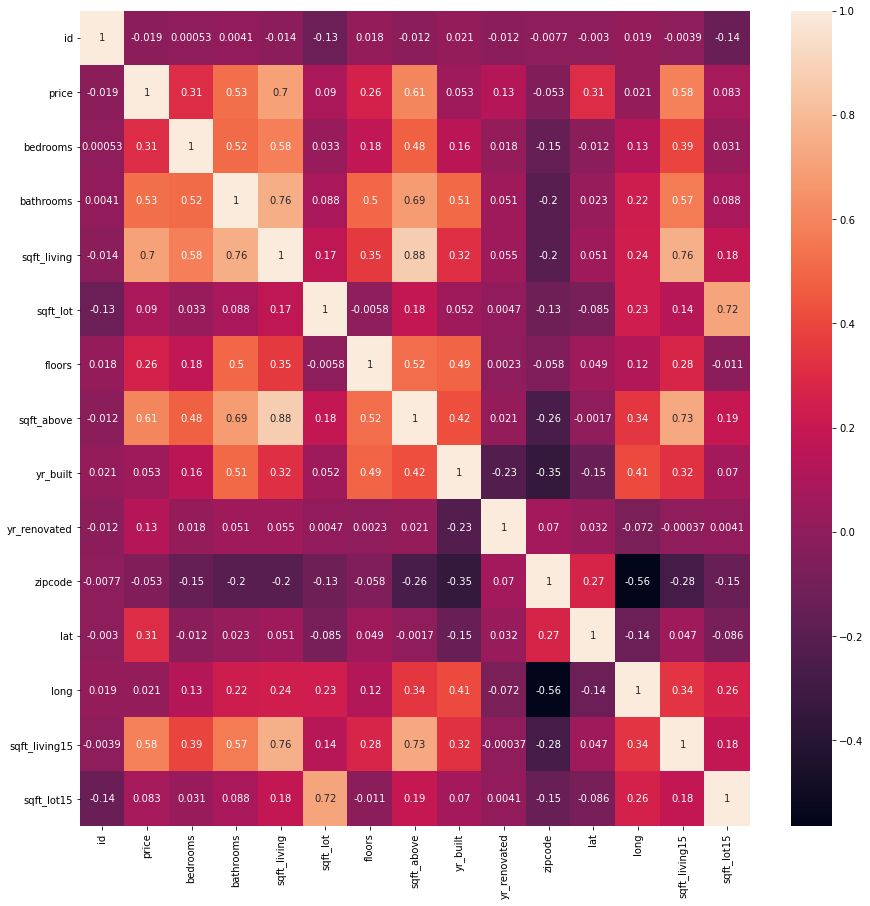

In [61]:
#looking at correlations
fig, ax = plt.subplots(figsize=(15,15))
heat = sns.heatmap(df_copy.corr(), annot = True)

Observations from this heatmap:

- We'll likely need to use a **mask** on this heatmap in order to create a more readable visualization that focuses on relevant features/columns.
- `sqft_living` has the highest correlation with price...
    - ...but `sqft_living` is also correlated with several other columns: `sqft_living15`, `sqft_above`, `bathrooms`, and `bedrooms`, so we'll likely need to choose just one of these features in order to minimize multicollinearity.
- `zipcode`, `lat`, and `long` all have low (0.31 or below) correlations with `price` - these columns likely won't be useful to us in constructing models for this project, but could be worth looking into as next-step recommendations.

Below, we group the dataset by column `view` and get some descriptive statistics on the column.

In [62]:
df_copy.groupby('view').mean()

df_copy.sort_values('price', ascending = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,7700000.00,6,8.00,12050,27600,2.50,NO,GOOD,Good,13 Mansion,8570,3480.0,1910,1987.00,98102,47.63,-122.32,3940,8800
3910,9808700762,6/11/2014,7060000.00,5,4.50,10040,37325,2.00,YES,AVERAGE,Average,11 Excellent,7680,2360.0,1940,2001.00,98004,47.65,-122.21,3930,25449
9245,9208900037,9/19/2014,6890000.00,6,7.75,9890,31374,2.00,NO,EXCELLENT,Average,13 Mansion,8860,1030.0,2001,0.00,98039,47.63,-122.24,4540,42730
4407,2470100110,8/4/2014,5570000.00,5,5.75,9200,35069,2.00,NO,NONE,Average,13 Mansion,6200,3000.0,2001,nan,98039,47.63,-122.23,3560,24345
1446,8907500070,4/13/2015,5350000.00,5,5.00,8000,23985,2.00,NO,EXCELLENT,Average,12 Luxury,6720,1280.0,2009,0.00,98004,47.62,-122.22,4600,21750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18453,7999600180,5/29/2014,83000.00,2,1.00,900,8580,1.00,NO,NONE,Average,5 Fair,900,0.0,1918,0.00,98168,47.47,-122.27,2060,6533
2139,1623049041,5/8/2014,82500.00,2,1.00,520,22334,1.00,NO,NONE,Fair,5 Fair,520,0.0,1951,0.00,98168,47.48,-122.30,1572,10570
16184,3028200080,3/24/2015,81000.00,2,1.00,730,9975,1.00,NaN,NONE,Poor,5 Fair,730,0.0,1943,0.00,98168,47.48,-122.31,860,9000
465,8658300340,5/23/2014,80000.00,1,0.75,430,5050,1.00,NaN,NONE,Fair,4 Low,430,0.0,1912,0.00,98014,47.65,-121.91,1200,7500


Visually the price of average, fair and good look the about the same so we would need to run a significance test and visualize the data to see. Excellent and none looks to be potentially significant. Need to use anova here to see and ad-hoc tests

In [63]:
# Dropping irrelevant columns
df_copy.drop(columns = ['id', 'floors', 'waterfront',
                        'bathrooms', 'bedrooms',
                        'lat', 'long', 'condition',
                        'yr_built', 'yr_renovated', 
                        'sqft_lot', 'sqft_lot15',
                        'sqft_above', 'sqft_living15',
                        'zipcode', 'sqft_basement'],
                        inplace=True)

In [64]:
df_copy.head()

,date,price,sqft_living,view,grade
2494,9/16/2014,280000.00,2400,NONE,7 Average
6729,5/8/2014,647500.00,2060,NONE,8 Good
8404,8/11/2014,400000.00,1460,NONE,7 Average
8800,4/1/2015,235000.00,1430,NONE,6 Low Average
3553,3/19/2015,402500.00,1650,NONE,7 Average


In [94]:
# df_copy['grade'].value_counts()

In [93]:
# fig, ax = plt.subplots(figsize=(20,10))

# sns.histplot(df_copy['grade'])

### Initiating `train_test_split`

In [65]:
# Establishing target and predictor variables
X = df_copy.drop(columns = 'price')
y = df_copy.price

In [66]:
# Creating variables for train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [67]:
train_df = pd.concat([X_train, y_train], axis=1)

test_df = pd.concat([X_test, y_test], axis=1)

In [95]:
# fig, ax = plt.subplots(figsize=(8,8))
# heat = sns.heatmap(train_df.corr(), annot = True)

### View Analysis

is there a difference between those that have a view versus those that don't

In [105]:
summary_of_view = df_copy.groupby('view').agg(['mean', 'std'])

summary_of_view

price           sqft_living        
                mean       std        mean     std
view                                              
AVERAGE    791956.68 510351.93     2651.20 1133.59
EXCELLENT 1453795.18 934351.44     3337.17 1544.93
FAIR       814386.56 513226.70     2573.51 1042.89
GOOD       972809.66 615049.87     3012.47 1204.88
NONE       497472.12 287602.07     2001.17  837.19

Observations from this summary:

- Significant gap between `EXCELLENT` and `GOOD`
- Smallest gap is between `FAIR` and `AVERAGE` - we'll need to determine if this difference is a signficant one.

From the df summary, we notice that there is a difference in price between price for those that are excellent
compared to those that have a view written as none. Further investigation will be performed to determine if this
difference is statistically significant

In [70]:
# Figure out how to do this in a loop/function?
df_average = train_df[train_df['view'] == 'AVERAGE']
df_excellent = train_df[train_df['view'] == 'EXCELLENT']
df_fair = train_df[train_df['view'] == 'FAIR']
df_good = train_df[train_df['view'] == 'GOOD']
df_none = train_df[train_df['view'] == 'NONE']

In [106]:
train_df['view'].value_counts()

NONE         12906
AVERAGE        636
GOOD           342
FAIR           213
EXCELLENT      212
Name: view, dtype: int64

Subsetting the data into different views
 - Number of rows:
     - `NONE` = 12906
     - `AVERAGE` = 636
     - `GOOD` = 342
     - `FAIR` = 213
     - `EXCELLENT` = 212

In [107]:
fvalue, pvalue = stats.f_oneway(df_average['price'], df_excellent['price'], df_fair['price'],
                                df_good['price'] , df_none['price'])

In [108]:
#creating df of just view
df_view = train_df[['view', 'price']]

#Tukey test
print(pairwise_tukeyhsd(df_view['price'], df_view['view']))

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1    group2    meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------
  AVERAGE EXCELLENT  661381.9591 0.001   587260.9579  735502.9603   True
  AVERAGE      FAIR     632.3693   0.9   -73358.0221   74622.7607  False
  AVERAGE      GOOD  153508.7996 0.001    90837.6508  216179.9484   True
  AVERAGE      NONE -304411.2575 0.001  -342373.9367 -266448.5783   True
EXCELLENT      FAIR -660749.5898 0.001  -751422.2948 -570076.8848   True
EXCELLENT      GOOD -507873.1595 0.001  -589571.5946 -426174.7244   True
EXCELLENT      NONE -965793.2166 0.001 -1030508.9521 -901077.4811   True
     FAIR      GOOD  152876.4303 0.001    71296.4726   234456.388   True
     FAIR      NONE -305043.6268 0.001  -369609.7296 -240477.5241   True
     GOOD      NONE -457920.0571 0.001  -509124.3196 -406715.7946   True
---------------------------------------------------

`AVERAGE` and `FAIR` are not significant to each other, so they should be grouped together. Each other subset should be on their own as they have a p value of < .05

#### Grade Analysis

 Is there a difference between grades

In [111]:
train_df.grade.value_counts()

7 Average        5939
8 Good           4008
9 Better         1756
6 Low Average    1353
10 Very Good      730
11 Excellent      268
5 Fair            169
12 Luxury          60
4 Low              17
13 Mansion          8
3 Poor              1
Name: grade, dtype: int64

Issues that may be present here:
- Only a single record for `grade` value of `3 Poor`
- `grade` is type `object`, so we'll need to convert it in the encoding process.

In [74]:
# Dropping poor row, since there is only one
df3 = train_df.copy()
df3 = df3[df3['grade'] != '3 Poor']

In [75]:
# Might need a for loop or a function here
df_10 = train_df[train_df['grade'] == '10 Very Good']
df_11 = train_df[train_df['grade'] == '11 Excellent']
df_12 = train_df[train_df['grade'] == '12 Luxury']
df_4 = train_df[train_df['grade'] == '4 Low']
df_5 = train_df[train_df['grade'] == '5 Fair']
df_6 = train_df[train_df['grade'] == '6 Low Average']
df_7 = train_df[train_df['grade'] == '7 Average']
df_8 = train_df[train_df['grade'] == '8 Good']
df_9 = train_df[train_df['grade'] == '9 Better']

In [114]:
# Finding f-statistic and p-value using ANOVA testing

f_value_grade, p_value_grade = stats.f_oneway(df_10['price'], df_11['price'], df_12['price'],
                                              df_4['price'], df_5['price'], df_6['price'],
                                              df_7['price'], df_8['price'], df_9['price'])
p_value_grade

0.0

This 0.0 value indicates there is significance **somewhere** between `grade` values, but additional testing is required to determine **where** exactly this significance exists.

There is a significant difference in price betweeen grades but we don't know which one is significant.
Further testing required to determine which is important

In [115]:
# Ad-hoc test to determine differeces in price vs. grade

df_grade = train_df[['grade', 'price']]

print(pairwise_tukeyhsd(df_grade['price'], df_grade['grade']))

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
    group1        group2       meandiff   p-adj      lower         upper     reject
-----------------------------------------------------------------------------------
 10 Very Good  11 Excellent   440093.1729  0.001    381286.075   498900.2708   True
 10 Very Good     12 Luxury  1204225.3694  0.001  1093647.0985  1314803.6403   True
 10 Very Good    13 Mansion  3538808.7027  0.001  3246113.8658  3831503.5397   True
 10 Very Good        3 Poor  -802941.2973 0.0642 -1626871.7649    20989.1704  False
 10 Very Good         4 Low  -845764.8267  0.001 -1047772.4292  -643757.2241   True
 10 Very Good        5 Fair  -811568.6582  0.001  -881854.5837  -741282.7327   True
 10 Very Good 6 Low Average  -759938.1731  0.001  -797749.9956  -722126.3506   True
 10 Very Good     7 Average  -661960.3897  0.001  -694253.1798  -629667.5996   True
 10 Very Good        8 Good  -522053.3614  0.001  -555186.7265  -488919.9963

Summary of what we notice

#### One Hot Encoding | Rework to include Train only

In [78]:
#categorizing average and fair together since they are not different from each other
df3['view'] = df3['view'].str.replace('AVERAGE', 'FAIR')

In [79]:
#making the categorical variable
cate_column = df3[['grade', 'view']]

cate_column

,grade,view
15502,7 Average,FAIR
7198,7 Average,NONE
7083,8 Good,NONE
21100,8 Good,NONE
2405,11 Excellent,NONE
...,...,...
17577,7 Average,NONE
5228,7 Average,NONE
10941,6 Low Average,NONE
4776,7 Average,NONE


In [80]:
ohe = OneHotEncoder(drop='first')

column_name = ['grade', 'view']
features = cate_column.copy()

features2 = features[column_name]

cate_ohe = ohe.fit_transform(features2)

cate_ohe

<14308x12 sparse matrix of type '<class 'numpy.float64'>'
	with 27674 stored elements in Compressed Sparse Row format>

In [116]:
name = ohe.get_feature_names_out()

In [117]:
cate_parsed = pd.DataFrame(cate_ohe.todense(), columns = name, index = features.index)
cate_parsed

,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,view_FAIR,view_GOOD,view_NONE
15502,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
7198,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
7083,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
21100,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
2405,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
17577,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
5228,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
10941,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
4776,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


### Scaling | Rework only to include train

In [83]:
# Creating dataframe with only numerical columns
numbers = train_df.select_dtypes(np.number)

In [118]:
#Rework to include only the train_df
ss = StandardScaler()

columns_name1 = ['price', 'sqft_living']
numbers_scaling = numbers.copy()

features= numbers_scaling[columns_name1]

scale1 = ss.fit(features)
scale2 = scale1.transform(features)
numbers_scaling[columns_name1] = scale2

numbers_scaling

,sqft_living,price
15502,-0.57,0.49
7198,0.88,0.24
7083,-0.21,0.12
21100,-0.60,-0.18
2405,2.20,1.14
...,...,...
17577,-0.78,-0.50
5228,-0.57,0.01
10941,-0.78,-0.70
4776,-1.02,-0.62


In [119]:
#combinig scale and ohe
scaled_and_parse_df = pd.concat([numbers_scaling, cate_parsed], axis = 1)

## Linear Regression | Rework so fit is only on train and not test

#### simple linear

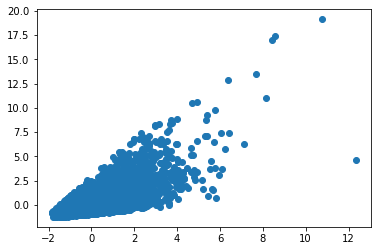

In [120]:
fig, ax = plt.subplots()

x = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']


ax.scatter(x, y);

In [121]:
np.corrcoef(df['sqft_living'],df['price'])

array([[1.       , 0.7019173],
       [0.7019173, 1.       ]])

Passing our first assumption: Based on our scatterplot, we can see that there is a strong correlation between `sqft_living` and price. Our pearson correlation coefficiant of `.70` suggests that these two variables are strongly correlated. Refer to the heatmap above re: multicollinearity.

In [126]:
# Baseline model
# Import necessary package
from sklearn.dummy import DummyRegressor

# Instantiate
dummy_lr = DummyRegressor()

# Create variables
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']

# Fit
dummy_lr.fit(X,y)

# Score
dummy_lr.score(X,y)

0.0

In [133]:
#Define X and y variable using scaled & parse dataframe

X_s_p = scaled_and_parse_df[['sqft_living']]
y_s_p = scaled_and_parse_df[['price']]

In [135]:
sk_lr = LinearRegression()
sk_lr.fit(X_s_p, y_s_p)
preds = sk_lr.predict(y_s_p)

preds

C:\Users\toast\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- price
Feature names seen at fit time, yet now missing:
- sqft_living

  warnings.warn(message, FutureWarning)


array([[-0.60026739],
       [-0.00695116],
       [-0.67891322],
       ...,
       [-0.26597564],
       [-0.26597564],
       [-0.40674982]])

In [158]:
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df[['price']]

In [159]:
resids = y - preds
resids

,price
0,-0.26
1,-0.00
2,-0.29
3,0.05
4,-0.03
...,...
21590,0.37
21592,-0.14
21593,-0.11
21595,-0.11


In [160]:
#Create out bins

bins = int( len(X)**.5)
bins

119

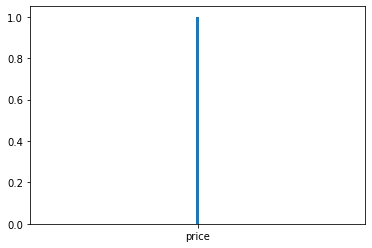

In [165]:
# Histogram of residuals

plt.hist(resids, bins=bins);

In [163]:
print(resids.max())
resids.min()

price   5.71
dtype: float64


price   -0.37
dtype: float64

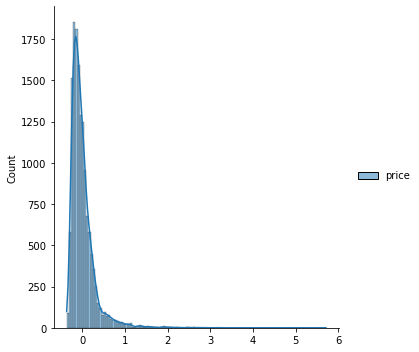

In [149]:
sns.displot(resids, bins=bins, kde=True)

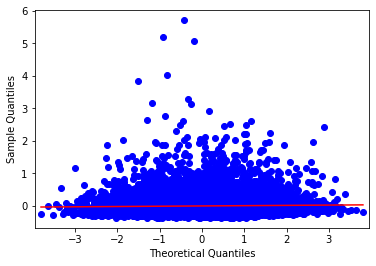

In [166]:
sm.qqplot(resids, line='r');

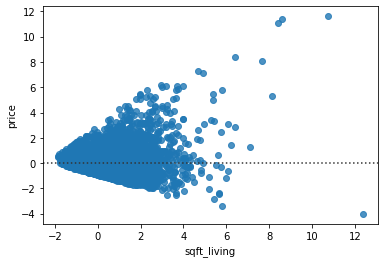

In [167]:
# resid plot sns.resid

sns.residplot(x=X, y=y);

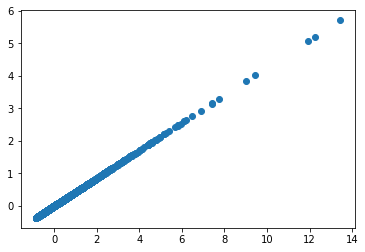

In [169]:
plt.scatter(preds, resids);

In [ ]:
#Fit the dummy_regressor

dummy_reg.fit(X_s_p,y_s_p)

In [ ]:
# Score it

dummy_reg.score(X_s_p,y_s_p)

In [ ]:
# Creating a straightforward, initial model --
# just for kicks
simple_formula = 'price ~ sqft_living'
simple_model = ols(formula = simple_formula,
                   data = scaled_and_parse_df).fit()
simple_mod_summ = simple_model.summary()

simple_mod_summ

In [ ]:
#test on our test data set

Summary comparison between the two

#### Multiple regression | Rework to train data

Slowly adding in other variables

In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))

x1 = scaled_and_parse_df[['sqft_living']]
y1 = scaled_and_parse_df[['price']]

x2 = scaled_and_parse_df[['bedrooms']]

ax[0].scatter(x1, y1)
ax[1].scatter(x2,y1);

#Upon looking at our scaled dataframe, we noticed that there is a house sold with 33 bedrooms for $600k
#After considering the price sold, sqft and number of bathrooms - the # of bedrooms appears 
#to be an error of somesort
#Since we explored bedrooms having a relatively small correlation to price, we are not too worried about this one
#outlier being included in our scatterplot

In [ ]:
simple_formula3 = 'price ~ sqft_living + bedrooms'
simple_model3 = ols(formula = simple_formula3,
                   data = scaled_and_parse_df).fit()
simple_mod_summ3 = simple_model3.summary()

simple_mod_summ3

## Next Steps:

- `bathrooms` and `bedrooms` - they are collinear with variables like `sqft_living`, which prevented us from including them in our model, but they might be useful avenues for further exploration.
- `waterfront` - our EDA demonstrated a significant difference in `price` between homes with waterfront views vs. homes without; it may be worth further exploring what development opportunities exist in waterfront areas.
- `zipcode` - taking a look at what neighborhoods/geographic areas yield high sale prices.
    - Look at interaction items: if homes with `EXCELLENT` views are concentrated in certain areas, perhaps.